# 电池数据异常检测
### 此notebook为异常检测比赛的参考DEMO，包括数据划分、模型训练和结果检测等

In [1]:
from os.path import join, split
import numpy as np
import pandas as pd
import random
import torch
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from glob import glob
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [30]:
from scipy.interpolate import interp1d
def load_data(pkl_list,label=True):
    '''
    输入pkl的列表，进行文件加载
    label=True用来加载训练集
    label=False用来加载真正的测试集，真正的测试集无标签
    '''
    X = []
    y = []
    
    for each_pkl in tqdm(pkl_list):
        item = torch.load(each_pkl)
        # LSTM读取所有数据，但不考虑时间戳间隔不一致的问题
        # 形成的X array形状变为 n×(256×9)
        item_x = np.array(item[0][:,0:7])
        timestamp = item[0][:,7]
        timefrom = timestamp[0]
        timeto = timestamp[-1]
        duration = timeto - timefrom
        n_timestep =item_x.shape[0]
        new_time = np.linspace(timefrom, timeto, n_timestep)  # 均匀分布
        for i in range(7):
            f = interp1d(timestamp, item_x[:, i])
            item_x[:, i] = f(new_time)
        item_x = np.hstack([item_x, np.log(duration) * np.ones([n_timestep, 1]), 
                            np.log(1 + item[1]['mileage']) * np.ones([n_timestep, 1])])
        X.append(item_x)
        if label:
            y.append(int(item[1]['label'][0]))
    X = np.array(X)
    if label:
        y = np.vstack(y)
    return X, y

In [3]:

def BuildLSTM(TimeStep, InputColNum, OutStep, MiddleNeurons, optimizer, HiddenActi = 'tanh', ConvFilter=8):
    """
    Parameters
    ----------
    TimeStep : int
        每个sample的序列长度，这个case里是256
    InputColumnNum : int
        特征数，目前是7
    OutStep : int
        输出序列长度，这里分类预测长度为1
    MiddleNeurons : list
        LSTM及全连接层神经元数
    HiddenActi : str
        tf支持的激活函数
    LearnRate : float
        keras.optimizers.Adam学习率

    Returns
    -------
    keras.models.Models的Model类对象
    """
    
    #输入层
    InputLayer = keras.layers.Input(shape = (TimeStep, InputColNum))
    
    #中间层，一层LSTM加若干全连接层
    Middle = []
    shrink_ratio = TimeStep // MiddleNeurons[0]
    Middle.append(keras.layers.AveragePooling1D(pool_size=shrink_ratio, strides=shrink_ratio, padding="valid")(InputLayer))
    Middle.append(keras.layers.SeparableConv1D(filters=ConvFilter, kernel_size=MiddleNeurons[0], strides=MiddleNeurons[0], padding="valid", activation=HiddenActi)(Middle[-1]))
    # Middle.append(keras.layers.LSTM(MiddleNeurons[0], activation = HiddenActi)(Middle[-1]))
    Middle.append(keras.layers.Flatten()(Middle[-1]))
    for NeuronNum in MiddleNeurons[1:]:
        Middle.append(keras.layers.Dense(NeuronNum, activation = HiddenActi)(Middle[-1]))
    
    #全连接输出层
    OutputLayer = keras.layers.Dense(OutStep, activation = 'sigmoid')(Middle[-1])
    
    Model = keras.models.Model(inputs = InputLayer, outputs = OutputLayer)
    #from_logits = False对应经过softmax函数的输出
    Model.compile(optimizer = optimizer, loss = keras.losses.BinaryCrossentropy(from_logits = False),
                  metrics = ['binary_accuracy'])
    Model.summary()
    return Model
    

In [4]:

def evaluate(label,score):
    fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
    AUC = auc(fpr, tpr)
    # AUC2 = 0
    # pos_id = np.argwhere(label > 0.5).T[0]
    # neg_id = np.argwhere(label < 0.5).T[0]
    # pos_score = score[pos_id]
    # neg_score = score[neg_id]
    # for ps in pos_score:
    #     AUC2 += np.sum((neg_score < ps) * 1.) + np.sum((neg_score == ps) * 0.5)
    # AUC2 = AUC2 / (len(pos_score) * len(neg_score))
    return AUC   
    

In [22]:
from pathlib import Path
__file__ = str(Path.cwd()) + '/1'

data_path = join(split(split(__file__)[0])[0], 'static', 'train')
# data_path = './train'
pkl_files = glob(data_path+'/*.pkl')

random.seed(1)
#排序并打乱存放车辆序号的集合
random.shuffle(pkl_files)

pos_pkl_files = []
neg_pkl_files = []
for f in pkl_files:
    pkl_data = torch.load(f)
    if int(pkl_data[1]['label'][0]) == 1:
        pos_pkl_files.append(f)
    else:
        neg_pkl_files.append(f)
n_pos = len(pos_pkl_files)
n_neg = len(neg_pkl_files)


In [35]:

train_pkl_files=[]
test_pkl_files=[]
for i in range(n_pos):
    if i < n_pos//2:
        train_pkl_files.append(pos_pkl_files[i])
    else:
        test_pkl_files.append(pos_pkl_files[i])
for i in range(n_neg):
    if i < 5*n_pos//2:
        train_pkl_files.append(neg_pkl_files[i])
    else:
        test_pkl_files.append(neg_pkl_files[i])

random.seed(0)
#排序并打乱存放车辆序号的集合
random.shuffle(train_pkl_files)

X_train0,y_train=load_data(train_pkl_files)
X_test0,y_test=load_data(test_pkl_files)


100%|██████████| 14427/14427 [00:13<00:00, 1069.15it/s]


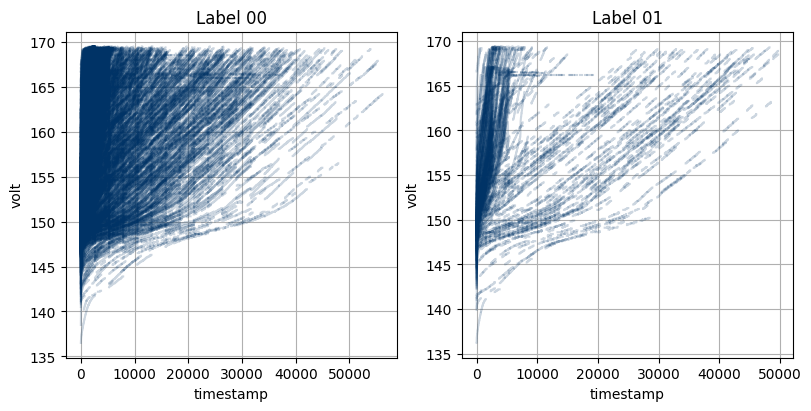

In [16]:
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=[8, 4])
# ax1, ax2 = axs
# ch_names = ['volt','current','soc','max_single_volt','min_single_volt','max_temp','min_temp','timestamp']
# y_ch = 0
# x_ch = 7
# for i in range(X_train.shape[0]):
#     x_var = X_train[i, :, x_ch]
#     y_var = X_train[i, :, y_ch]
#     if y_train[i, 0] < 0.5:
#         ax1.plot(x_var, y_var, color='#00336633')
#     else:
#         ax2.plot(x_var, y_var, color='#00336633')
# xlabel = ch_names[x_ch]
# ylabel = ch_names[y_ch]
# ax1.set_xlabel(xlabel)
# ax1.set_ylabel(ylabel)
# ax1.set_title('Label 00')
# ax2.set_xlabel(xlabel)
# ax2.set_ylabel(ylabel)
# ax2.set_title('Label 01')
# ax1.grid(True)
# ax2.grid(True)
# plt.show()

In [43]:
# 归一化
# _mean = np.mean(X_train, axis=(0,1))
# _std = np.std(X_train, axis=(0,1))
_mean = np.array([152.5, -25., 30., 1.7, 1.7, 150., 150., 7. , 8.])
_std  = np.array([17.5 , 25. , 30., 0.3, 0.3, 150., 150., 1.5, 5.])
X_train = (X_train0 - _mean) / (_std + 1e-4)
X_test = (X_test0 - _mean) / (_std + 1e-4)

MiddleNeurons = [4, 4]
HiddenActi = 'tanh'
ConvFilter = 6
epochs = 200
BatchSize = 64
_, n_timestep, n_feat = X_train.shape
# optimizer = keras.optimizers.RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = keras.optimizers.Adam(learning_rate = 5e-4)

LSTMModel = BuildLSTM(n_timestep, n_feat, 1, MiddleNeurons, HiddenActi = HiddenActi, optimizer=optimizer, ConvFilter=ConvFilter)

# 载入模型
# LSTMModel = keras.models.load_model(join(split(__file__)[0], 'LSTMModel'))

EarlyStop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20)

# log路径打开cmd，运行tensorboard --logdir = train，浏览器访问localhost:6006
# LogDir = 'LSTMlog'
LogDir = join(split(__file__)[0], 'LSTMlog')
TensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir = LogDir, histogram_freq = 10)

# def adapt_learning_rate(epoch):
#     return 3e-3 * (10 / (10 + max(0, epoch - 20)))
# my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)
# history = LSTMModel.fit(X_train, y_train, epochs = epochs, batch_size = BatchSize, validation_split = 0.2, verbose = 1,
#                         callbacks = [TensorboardCallback, EarlyStop, my_lr_scheduler], shuffle=False)

for epoch in range(epochs):  # 手动shuffle batch样本，相当于固定fit中shuffle的种子，慢但可重复
    indices = np.arange(X_train.shape[0])
    random.seed(epoch+2077)
    random.shuffle(indices)
    print('Epoch %d/%d'%(epoch+1,epochs))
    def adapt_learning_rate(ignored_epoch):
        decay_epochs = epochs
        alpha = 1e-3
        initial_learning_rate = 1e-2
        warmup_epochs = 20
        x = min(epoch, decay_epochs)
        warmup = min(x / warmup_epochs, 1.)
        cosine_decay = 0.5 * (1 + np.cos(np.pi * x / decay_epochs))
        decayed = (1 - alpha) * cosine_decay ** 2 * warmup + alpha
        return initial_learning_rate * decayed
    my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)
    history = LSTMModel.fit(X_train[indices], y_train[indices], epochs=1, batch_size=BatchSize, validation_split=0.2, verbose=1,
                            callbacks=[TensorboardCallback, EarlyStop, my_lr_scheduler], shuffle=False)

# yTrainPred = LSTMModel.predict(X_train)
yTestPred = LSTMModel.predict(X_test)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 9)]          0         
                                                                 
 average_pooling1d_6 (Averag  (None, 4, 9)             0         
 ePooling1D)                                                     
                                                                 
 separable_conv1d_6 (Separab  (None, 1, 6)             96        
 leConv1D)                                                       
                                                                 
 flatten_6 (Flatten)         (None, 6)                 0         
                                                                 
 dense_12 (Dense)            (None, 4)                 28        
                                                                 
 dense_13 (Dense)            (None, 1)                 5   

AUC1  = 0.9963925104859589
yTestPred minmax =  2.7210511e-08 ,  0.99999684


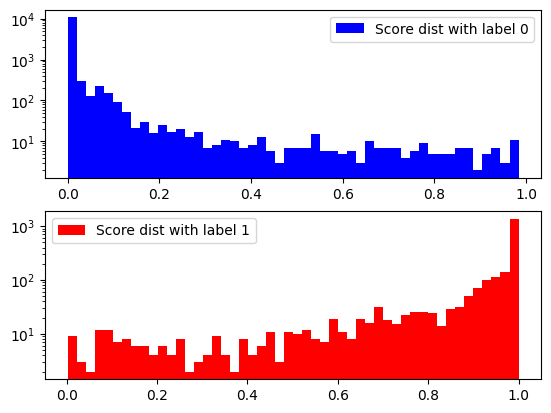

In [44]:

AUC1 = evaluate(y_test, yTestPred)
print('AUC1  =', AUC1)
# print('yTrainPred minmax = ', np.min(yTrainPred), ', ', np.max(yTrainPred))
print('yTestPred minmax = ', np.min(yTestPred), ', ', np.max(yTestPred))
pos_score = yTestPred[np.argwhere(y_test >= 0.5).T[0], 0]
neg_score = yTestPred[np.argwhere(y_test < 0.5).T[0], 0]

fig, axs = plt.subplots(2)
axs[0].hist(neg_score, bins=50, log=True, color='b', label='Score dist with label 0')
axs[1].hist(pos_score, bins=50, log=True, color='r', label='Score dist with label 1')
axs[0].legend()
axs[1].legend()
plt.show()


In [46]:

LSTMModel.save(join(split(__file__)[0], 'LSTMModel'), 'LSTMModel')
# LSTMModel.save('./LSTMModel', 'LSTMModel')

testA_path = join(split(split(__file__)[0])[0], 'static', 'test_A')
# testA_path = './test_A'
testA_pkl_files = glob(testA_path+'/*.pkl')
X_testA, y_testA = load_data(testA_pkl_files, label = False)
X_testA = (X_testA - _mean) / (_std + 1e-4)
yTestAPred = LSTMModel.predict(X_testA)
predict_score = pd.DataFrame([split(fname)[1] for fname in testA_pkl_files])
predict_score = pd.concat([predict_score, pd.DataFrame(yTestAPred)], axis = 1)
predict_score.columns = ['file_name', 'score']
predict_score = predict_score.sort_values(by='file_name')
# predict_score.to_csv('submission.csv')
predict_score.to_csv(join(split(__file__)[0], 'submission.csv'), index=False)


INFO:tensorflow:Assets written to: /Users/leehangyue/Code/vloong-Anomaly-detection-master/repo_20220918/LSTMModel/assets


INFO:tensorflow:Assets written to: /Users/leehangyue/Code/vloong-Anomaly-detection-master/repo_20220918/LSTMModel/assets
100%|██████████| 6234/6234 [00:03<00:00, 1738.30it/s]


195/195 [==============================] - 0s 461us/step
